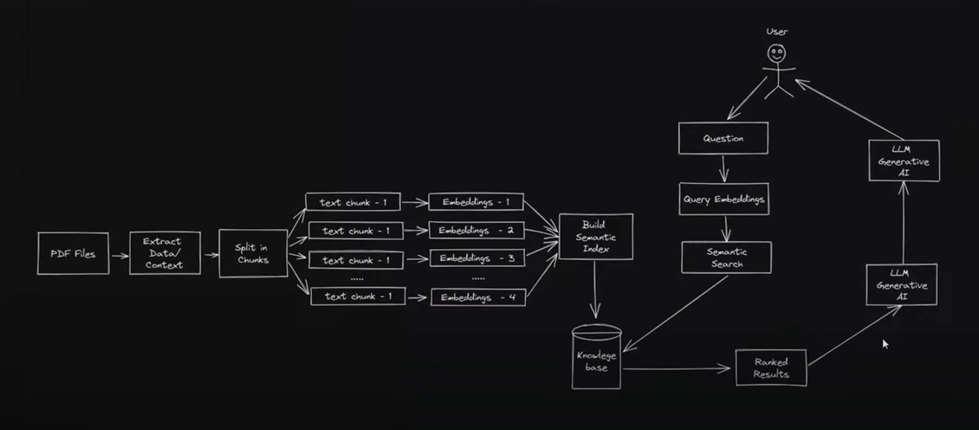

**Embedding Model** : all-MiniLM-L6-v2

**Vector Database** : FAISS

**Proprietary Data** : 6 PDF of Halliburton
                
                ["FactSheet_Climate_Jobs_2024.pdf",
             "Short-Term Energy Outlook.pdf",
             "halliburton-announces-1st-quarter-2023-results.pdf",
             "halliburton-announces-2nd-quarter-2023-results.pdf",
             "halliburton-announces-3rd-quarter-2023-results.pdf",
             "halliburton-announces-4th-quarter-2023-results.pdf"]

**LLM**: mistral-7b

**Model Description**:

 Mistral 7B is a cutting-edge 7.3 billion parameter language model developed by Mistral AI, showcasing remarkable advancements in the realm of Large Language Models (LLMs). This model has outperformed larger models like Llama 2 13B and Llama 1 34B across various tasks, approaching the performance of CodeLlama 7B on code-related tasks while excelling in English language tasks. Mistral 7B incorporates innovative features like Grouped-query Attention (GQA) for faster inference and Sliding Window Attention (SWA) to handle longer text sequences efficiently. Mistral 7B's architecture includes unique elements like Sliding Window Attention, Rolling Buffer Cache, and Knowledge-based assessments, contributing to its exceptional performance in tasks such as code generation, natural language processing, creative writing, education, and research. Additionally, Mistral 7B stands out for its cost-effectiveness, requiring fewer computational resources compared to models of similar size, and its versatile deployment options, allowing users to run it on various platforms. Mistral 7B's fine-tuning capabilities make it adaptable to different tasks, showcasing its potential for real-world applications and its ability to be fine-tuned for specific purposes like chat interactions

 # Summary :

1. Here I've implemented a conversational chatbot using the Mistral-7B-Instruct model.
2. Started the challenge by loading PDF files from a specified folder, converting them to text, and then creating a vector store to index the text for efficient retrieval.
3. Used the Mistral-7B-Instruct model for generating responses based on the user's queries.
4. The chatbot successfully responded to user queries based on the content of the PDF files.
5. Evaluated the responses and observed that the chatbot provided relevant and informative answers to a variety of questions.

#RAG Workflow

#Installing the necessary dependencies

In [ ]:
!pip install langchain
#!pip install torch
!pip install sentence_transformers
!pip install faiss-cpu
!pip install huggingface-hub
!pip install pypdf
#!pip -q install accelerate
!pip install llama-cpp-python
!pip -q install git+https://github.com/huggingface/transformers

#Import various classes from the LangChain library. It is used for integrating different components of the language model pipeline

In [ ]:
from langchain.chains import RetrievalQA
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import LlamaCpp
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.document_loaders import PyPDFLoader

#STEP 1 : Load the model

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Import Model
llm = LlamaCpp(
    streaming=True,  # Indicates whether streaming generation is enabled
    model_path="/content/drive/My Drive/Model/mistral-7b-instruct-v0.1.Q4_K_S.gguf",  # Path to the pre-trained model
    temperature=0.75,  # Controls the randomness of generated text (lower values produce more conservative outputs)
    top_p=1,  # Controls nucleus sampling for generating diverse and relevant responses
    verbose=True,  # Enables verbose mode for additional output during generation
    n_ctx=4096  # Size of the input context window for the model
)

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /content/drive/My Drive/Model/mistral-7b-instruct-v0.1.Q4_K_S.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv  

#STEP 2 : Load the data PDF data


---
 Utilize the PyPDF library to load PDF files
 1. Creating the Loader Object: Create an instance of a loader object from the PyPDF library using the PyPDFDirectoryLoader class.

2. Loading PDF Files: The load() method reads all the PDF files located in the specified directory and prepares them for further processing.

In [ ]:
#load pdf files
loader = PyPDFDirectoryLoader("/content/drive/MyDrive/Coding challenge-LLM/Dataset/")
data = loader.load()

In [ ]:
print(data)

#STEP 3 : Split extracted data into smaller text chunks using the RecursiveCharacterTextSplitter from the Langchain library

---



In [ ]:
#Step 03: Split the Extracted Data into Text Chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=200)
text_chunks = text_splitter.split_documents(data)

In [ ]:
len(text_chunks)

1107

In [ ]:
#get the third chunk
text_chunks[2]

Document(page_content='independent of approval by any other officer or employe e of the U.S. Government. The views in this \nreport do not represent those of DO E or any other federal agencies.', metadata={'source': '/content/drive/MyDrive/Coding challenge-LLM/Dataset/Short-Term Energy Outlook.pdf', 'page': 1})

#STEP 4 : Download embeddings using the HuggingFaceEmbeddings module with a specified model name ("sentence-transformers/all-MiniLM-L6-v2").

---



In [ ]:
#Step 04:Downlaod the Embeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#STEP 5 : Generates embedding for each text chunk and creates a FAISS vector store using the extracted text chunks and embeddings.

---

In [ ]:
#Step 05: Create Embeddings for each of the Text Chunk
vector_store = FAISS.from_documents(text_chunks, embedding=embeddings)

#STEP 6 :

1. Set up a conversational retrieval chain by initializing a conversation memory and constructing the chain from the LLAMA model with a specified chain type.

2. The retriever for the chain is configured using a FAISS vector store with top-2 retrieval, and the conversation memory is incorporated into the chain.

---



In [ ]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

In [ ]:
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
chain = ConversationalRetrievalChain.from_llm(llm=llm, chain_type='stuff',
                                                 retriever=vector_store.as_retriever(search_kwargs={"k": 2}),
                                                 memory=memory)

#STEP 7 : Manual Evaluation

---



1. Query from a text selectable PDF

Source : halliburton-announces-1st-quarter-2023-results | Page no. : 1

In [ ]:
query = "Summarize HALLIBURTON FIRST QUARTER 2023 RESULTS "

In [ ]:
chain.run(query)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(

llama_print_timings:        load time =    3235.99 ms
llama_print_timings:      sample time =      71.72 ms /   128 runs   (    0.56 ms per token,  1784.79 tokens per second)
llama_print_timings: prompt eval time =  173496.41 ms /   400 tokens (  433.74 ms per token,     2.31 tokens per second)
llama_print_timings:        eval time =   78901.23 ms /   128 runs   (  616.42 ms per token,     1.62 tokens per second)
llama_print_timings:       total time =  253064.07 ms /   528 tokens


" Halliburton reported a net income of $0.72 per diluted share for the first quarter of 2023 , which is more than double the net income per diluted share in the same period last year. The company's revenue for the first quarter of 2023 was $5.7 billion , a 33% increase from the same quarter last year. Additionally, Halliburton's operating margin for the first quarter of 2023 was 17.2%, a 530 basis point increase from the same period last year."

In [ ]:
follow_up_query = "What is the Operating margin here?"

In [ ]:
chain.run(follow_up_query)

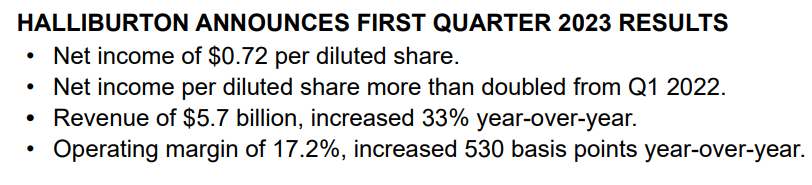

Asking questions which is not a part of vectorDB

In [ ]:
query = "What is RAG"
chain.run(query)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3235.99 ms
llama_print_timings:      sample time =      14.46 ms /    24 runs   (    0.60 ms per token,  1659.75 tokens per second)
llama_print_timings: prompt eval time =   70008.79 ms /   154 tokens (  454.60 ms per token,     2.20 tokens per second)
llama_print_timings:        eval time =   14023.61 ms /    23 runs   (  609.72 ms per token,     1.64 tokens per second)
llama_print_timings:       total time =   78082.65 ms /   177 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    3235.99 ms
llama_print_timings:      sample time =      15.57 ms /    28 runs   (    0.56 ms per token,  1798.21 tokens per second)
llama_print_timings: prompt eval time =  155893.20 ms /   365 tokens (  427.10 ms per token,     2.34 tokens per second)
llama_print_timings:        eval time =   16604.64 ms /    27 runs   (  614.99 ms per token,     1.63 tokens per second)
llama_print_timings:       to

' I do not have information on the revenue growth rate of Halliburton during the second quarter of 2023.'

The model concludes "RAG is not provided in the given context"  --- That's right.

In [ ]:
query = "What is Halliburton"
chain.run(query)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3235.99 ms
llama_print_timings:      sample time =       5.31 ms /     9 runs   (    0.59 ms per token,  1695.87 tokens per second)
llama_print_timings: prompt eval time =  191355.79 ms /   452 tokens (  423.35 ms per token,     2.36 tokens per second)
llama_print_timings:        eval time =    4767.13 ms /     8 runs   (  595.89 ms per token,     1.68 tokens per second)
llama_print_timings:       total time =  196301.54 ms /   460 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    3235.99 ms
llama_print_timings:      sample time =      45.78 ms /    81 runs   (    0.57 ms per token,  1769.41 tokens per second)
llama_print_timings: prompt eval time =  137158.68 ms /   322 tokens (  425.96 ms per token,     2.35 tokens per second)
llama_print_timings:        eval time =   45849.01 ms /    80 runs   (  573.11 ms per token,     1.74 tokens per second)
llama_print_timings:       to

'dash: Halliburton is a leading global provider of products and services to the energy industry. They were founded in 1919 and are known for their innovative technologies, products and services that help customers maximize the value throughout the life cycle of an asset and advance a sustainable energy future. They have a website and social media presence on LinkedIn, YouTube, Instagram, and Facebook.'

2. Query from a text selectable PDF

Source : Short-Term Energy Outlook.pdf | Page no. : 8 & 9


In [ ]:
query = "Summarize U.S. refinery operation and inventories"
chain.run(query)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    4147.93 ms
llama_print_timings:      sample time =      12.74 ms /    18 runs   (    0.71 ms per token,  1412.87 tokens per second)
llama_print_timings: prompt eval time =  174823.97 ms /   324 tokens (  539.58 ms per token,     1.85 tokens per second)
llama_print_timings:        eval time =   14479.24 ms /    17 runs   (  851.72 ms per token,     1.17 tokens per second)
llama_print_timings:       total time =  189523.28 ms /   341 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    4147.93 ms
llama_print_timings:      sample time =      41.71 ms /    64 runs   (    0.65 ms per token,  1534.33 tokens per second)
llama_print_timings: prompt eval time =  233601.26 ms /   437 tokens (  534.56 ms per token,     1.87 tokens per second)
llama_print_timings:        eval time =   57855.59 ms /    63 runs   (  918.34 ms per token,     1.09 tokens per second)
llama_print_timings:       to

' The current state of U.S. refinery operation and inventories is lower than in 2019 due to cold winter weather, planned refinery maintenance on the Gulf Coast, a major unplanned outage in the Midwest, and a decrease in refinery utilization by about 2%.'

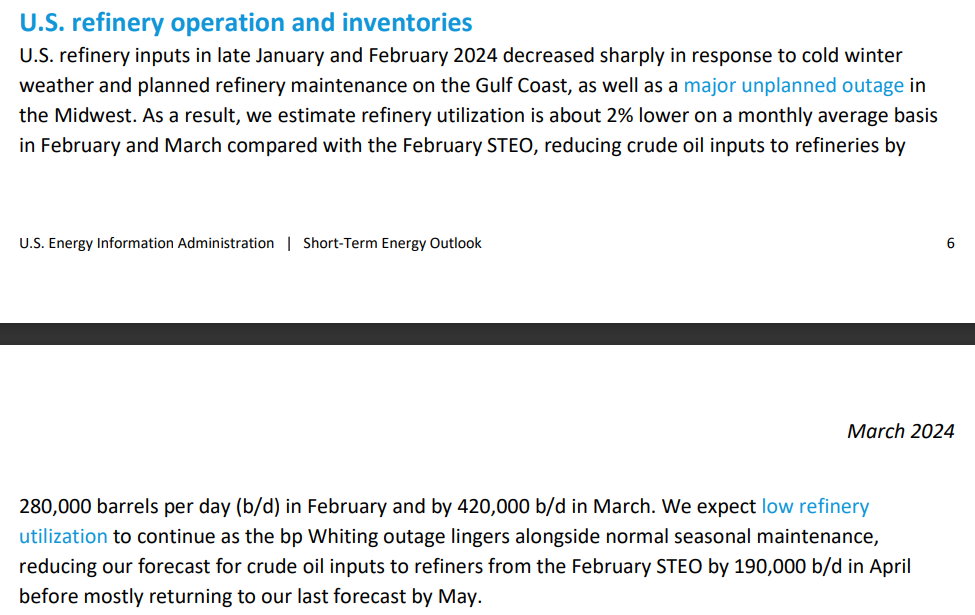

The response is correct.

3. Query related to the content of protected PDF

Source file : FactSheet_Climate_Jobs_2024.pdf | Page no. : 1

In [ ]:
query = "Renewable energy supported how many jobs in 2022?"
chain.run(query)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    4147.93 ms
llama_print_timings:      sample time =      11.66 ms /    17 runs   (    0.69 ms per token,  1457.73 tokens per second)
llama_print_timings: prompt eval time =  219713.83 ms /   411 tokens (  534.58 ms per token,     1.87 tokens per second)
llama_print_timings:        eval time =   13632.63 ms /    16 runs   (  852.04 ms per token,     1.17 tokens per second)
llama_print_timings:       total time =  233599.70 ms /   427 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    4147.93 ms
llama_print_timings:      sample time =      14.04 ms /    22 runs   (    0.64 ms per token,  1566.95 tokens per second)
llama_print_timings: prompt eval time =  197869.27 ms /   373 tokens (  530.48 ms per token,     1.89 tokens per second)
llama_print_timings:        eval time =   19078.61 ms /    21 runs   (  908.51 ms per token,     1.10 tokens per second)
llama_print_timings:       to

' Renewable energy supported 546,630 jobs in 2022.'

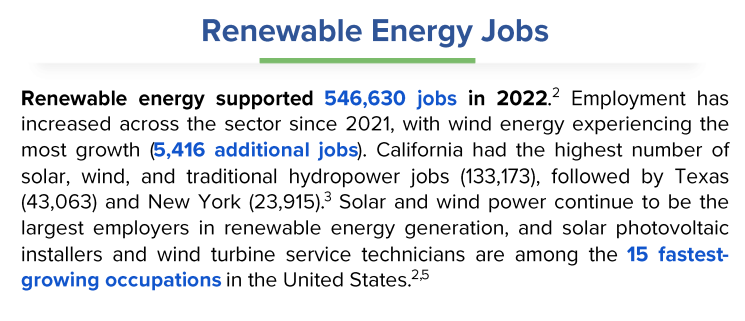

The response is correct

4. Query from a text-selectable PDF

Source : Short-Term Energy Outlook.pdf | Page no. : 15

In [ ]:
query = "What is BEA"
chain.run(query)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    4147.93 ms
llama_print_timings:      sample time =       4.45 ms /     6 runs   (    0.74 ms per token,  1348.31 tokens per second)
llama_print_timings: prompt eval time =  247004.92 ms /   445 tokens (  555.07 ms per token,     1.80 tokens per second)
llama_print_timings:        eval time =    4693.94 ms /     5 runs   (  938.79 ms per token,     1.07 tokens per second)
llama_print_timings:       total time =  251920.58 ms /   450 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    4147.93 ms
llama_print_timings:      sample time =      34.50 ms /    52 runs   (    0.66 ms per token,  1507.42 tokens per second)
llama_print_timings: prompt eval time =  248660.14 ms /   466 tokens (  533.61 ms per token,     1.87 tokens per second)
llama_print_timings:        eval time =   44384.81 ms /    51 runs   (  870.29 ms per token,     1.15 tokens per second)
llama_print_timings:       to

' Bureau of Economic Analysis (BEA) is a government agency responsible for measuring and publishing economic data in the United States. The BEA produces estimates of gross domestic product (GDP), personal income, consumption expenditures, and other economic indicators.'

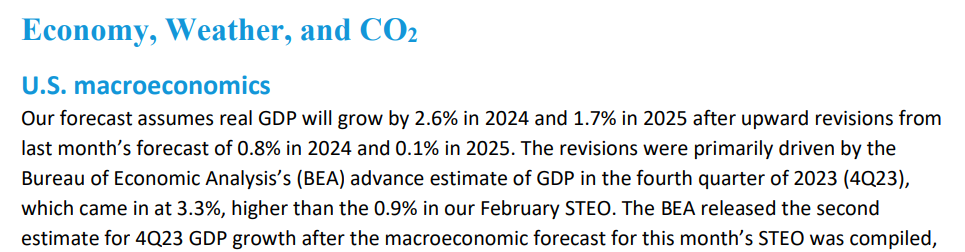

The response is correct.

5. Query from a text selectable PDF

Source : halliburton-announces-2nd-quarter-2023-results | Page no. : 3

In [ ]:
query = "During second quarter of 2023, Halliburton repurchased ___ of common stock?  "
chain.run(query)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3235.99 ms
llama_print_timings:      sample time =      15.65 ms /    26 runs   (    0.60 ms per token,  1660.92 tokens per second)
llama_print_timings: prompt eval time =   97028.97 ms /   226 tokens (  429.33 ms per token,     2.33 tokens per second)
llama_print_timings:        eval time =   17309.03 ms /    25 runs   (  692.36 ms per token,     1.44 tokens per second)
llama_print_timings:       total time =  114529.35 ms /   251 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    3235.99 ms
llama_print_timings:      sample time =      15.09 ms /    28 runs   (    0.54 ms per token,  1856.03 tokens per second)
llama_print_timings: prompt eval time =  119632.78 ms /   275 tokens (  435.03 ms per token,     2.30 tokens per second)
llama_print_timings:        eval time =   16305.97 ms /    27 runs   (  603.92 ms per token,     1.66 tokens per second)
llama_print_timings:       to

'xc Halliburton repurchased $248 million of common stock during the second quarter of 2023.'

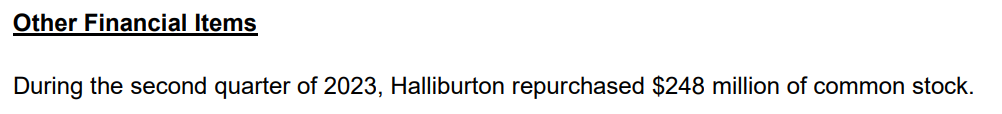

It is the precise response

6. Query from a text selectable PDF

Source : halliburton-announces-3rd-quarter-2023-results | Page no. : 2

In [ ]:
query = "Summarize the drilling and Evaluation of 3rd quarter 2023"
chain.run(query)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    4147.93 ms
llama_print_timings:      sample time =      17.00 ms /    25 runs   (    0.68 ms per token,  1470.76 tokens per second)
llama_print_timings: prompt eval time =  322637.58 ms /   584 tokens (  552.46 ms per token,     1.81 tokens per second)
llama_print_timings:        eval time =   21124.62 ms /    24 runs   (  880.19 ms per token,     1.14 tokens per second)
llama_print_timings:       total time =  344140.26 ms /   608 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    4147.93 ms
llama_print_timings:      sample time =      36.20 ms /    56 runs   (    0.65 ms per token,  1547.13 tokens per second)
llama_print_timings: prompt eval time =  163830.54 ms /   310 tokens (  528.49 ms per token,     1.89 tokens per second)
llama_print_timings:        eval time =   47850.83 ms /    55 runs   (  870.02 ms per token,     1.15 tokens per second)
llama_print_timings:       to

"  Halliburton's Drilling and Evaluation (D&E) revenue in the third quarter of 2023 was $1.0 billion, which represents a 3% increase when compared to the second quarter of 2023."

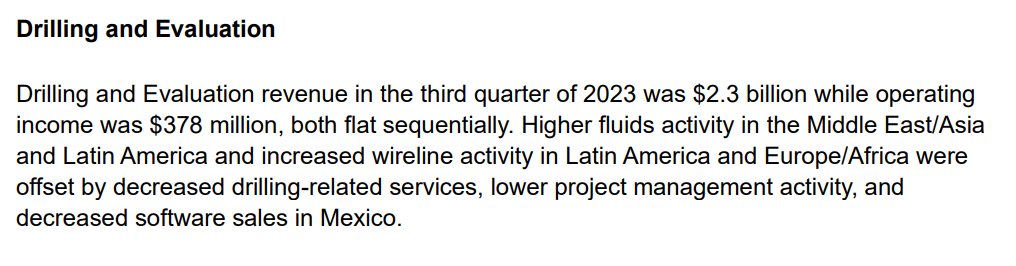

The response is incorrect

7. Query from a text selectable PDF

Source : halliburton-announces-3rd-quarter-2023-results | Page no. : 10

In [ ]:
query = "During third quarter of 2023, In condensed consolidated Statements of cash flows, What is the Total cash flows provided by operating activities?"
chain.run(query)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    4147.93 ms
llama_print_timings:      sample time =      14.56 ms /    22 runs   (    0.66 ms per token,  1510.89 tokens per second)
llama_print_timings: prompt eval time =  374629.35 ms /   679 tokens (  551.74 ms per token,     1.81 tokens per second)
llama_print_timings:        eval time =   17564.81 ms /    21 runs   (  836.42 ms per token,     1.20 tokens per second)
llama_print_timings:       total time =  392582.08 ms /   700 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    4147.93 ms
llama_print_timings:      sample time =      50.51 ms /    82 runs   (    0.62 ms per token,  1623.34 tokens per second)
llama_print_timings: prompt eval time =  252043.58 ms /   448 tokens (  562.60 ms per token,     1.78 tokens per second)
llama_print_timings:        eval time =   70701.49 ms /    82 runs   (  862.21 ms per token,     1.16 tokens per second)
llama_print_timings:       to

'  To find this information, we need to look at the reconciliation table on page 17.  The table shows the total cash flows provided by operating activities for the entire year, as well as for each quarter.  We can see from the table that for the third quarter of 2023, the total cash flows provided by operating activities were $1,410 million.'

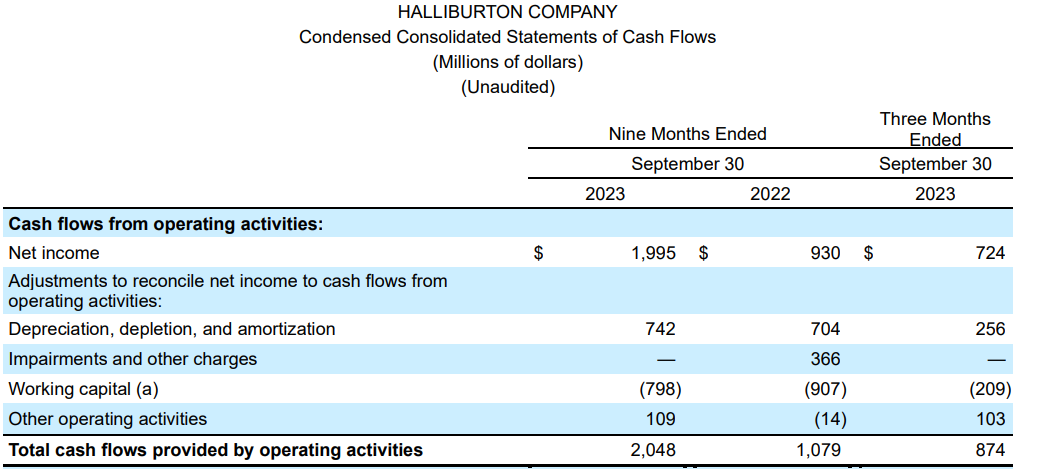

The response is incorrect.

8. Query from a text selectable PDF

Source : halliburton-announces-4th-quarter-2023-results | Page no. : 15

In [ ]:
query = "How Net income per diluted share is calculated ?"
chain.run(query)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    4147.93 ms
llama_print_timings:      sample time =       7.82 ms /    12 runs   (    0.65 ms per token,  1535.12 tokens per second)
llama_print_timings: prompt eval time =  436853.61 ms /   779 tokens (  560.79 ms per token,     1.78 tokens per second)
llama_print_timings:        eval time =    9145.23 ms /    11 runs   (  831.38 ms per token,     1.20 tokens per second)
llama_print_timings:       total time =  446412.24 ms /   790 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    4147.93 ms
llama_print_timings:      sample time =      43.08 ms /    66 runs   (    0.65 ms per token,  1532.21 tokens per second)
llama_print_timings: prompt eval time =  158624.37 ms /   274 tokens (  578.92 ms per token,     1.73 tokens per second)
llama_print_timings:        eval time =   54765.79 ms /    65 runs   (  842.55 ms per token,     1.19 tokens per second)
llama_print_timings:       to

'  Net income per diluted share is calculated by dividing net income attributable to the company by diluted weighted average common shares outstanding. Adjusted net income per diluted share is calculated by dividing adjusted net income attributable to the company by diluted weighted average common shares outstanding.'

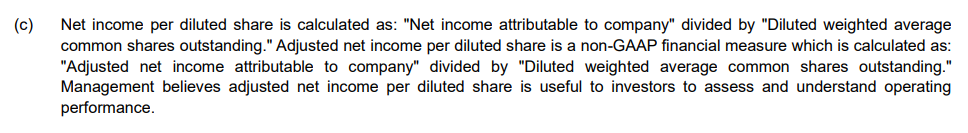



The response is correct